In [1]:
# basic packages imports
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# specific imports (from HR-tools library)
import HR_load as HRl      # to load Felicity 2 data (EDF format)
import ECG_tools as ECGt   # to convert ECG into peaks series
import HR_tools as HRt     # to convert peaks and RRI into HR:

## load ECG and RRI data from Felicity 2 files

In [3]:
# Define the path to the subfolder - update as needed
folder_path="/Users/ngarnier/Documents/research/data/2024-Felicity-2/2024-03-20-example/" #OneDrive_1_3-20-2024/"

# analysis parameters:
sampling_rate   = 1000 
# Flags to control whether to apply filtering and/or cleaning
apply_filtering = True #False
apply_cleaning  = True #False
# filter parameters (only used if apply_filtering is True):
method  ='butterworth'
order   = 4
lowcut  = 0.5
highcut = 40 

print("working in directory", folder_path)

total_files = 0
for filename in os.listdir(folder_path):
    if filename.endswith(".EDF"):
        print("file", filename, end=" ")
        ECG, RRI = HRl.edf_to_arr(os.path.join(folder_path, filename), verbosity=1)
        print("    -> ECG with shape", ECG.shape, "and RRI with shape", RRI.shape)
        RRI = HRt.clean_RRI(RRI)
        total_files += 1
        
        # check for NaNs:
        nb_NaNs = np.sum(np.isnan(ECG))
        if (nb_NaNs>0): print(nb_NaNs, "NaNs detected in the data!!!")

        # search for R-peaks in ECG data:
        # (provide filter parameters for tuning if wanted)
        peaks = ECGt.ECG_to_peaks(ECG, sampling_rate, do_filtering=apply_filtering, do_cleaning=apply_cleaning, \
                                  method=method, order=order, lowcut=lowcut, highcut=highcut, verbosity=1)

        RRI_from_ECG_peaks=[]
        for i in range(len(peaks)):
            RRI_from_ECG_peaks.append(HRt.peaks_to_RRI(peaks[i], sampling_rate=sampling_rate, interpolate=True))

print(total_files, "file analyzed")

working in directory /Users/ngarnier/Documents/research/data/2024-Felicity-2/2024-03-20-example/
file FE_002_02.05.2023.EDF   found 3 ECG channels and an HRV channel
    -> ECG with shape (3, 2917000) and RRI with shape (14585,)
    ECG channel 1 : 3785 peaks found, i.e., average HR about 77.85 bpm
    ECG channel 2 : 3791 peaks found, i.e., average HR about 77.98 bpm
    ECG channel 3 : 3800 peaks found, i.e., average HR about 78.16 bpm
1 file analyzed


## compute HR from RRI (either from device and ECG channels)

In [4]:
# HR
fs=20 # for output HR

# HR from device RRI:
HR          = HRt.RRI_to_HR(HRt.clean_RRI(RRI), sampling_rate=fs, rri_sampling_rate=5)
t_HR        = np.arange(HR.size)/fs

# HR from ECG RRI:
HR_from_ECG=[]
t_HR_from_ECG=[]
for i in range(len(RRI_from_ECG_peaks)):
    HR_from_ECG.append(HRt.RRI_to_HR(HRt.clean_RRI(RRI_from_ECG_peaks[i]), sampling_rate=fs, rri_sampling_rate=sampling_rate))
    t_HR_from_ECG.append(np.arange(HR_from_ECG[i].size)/fs)

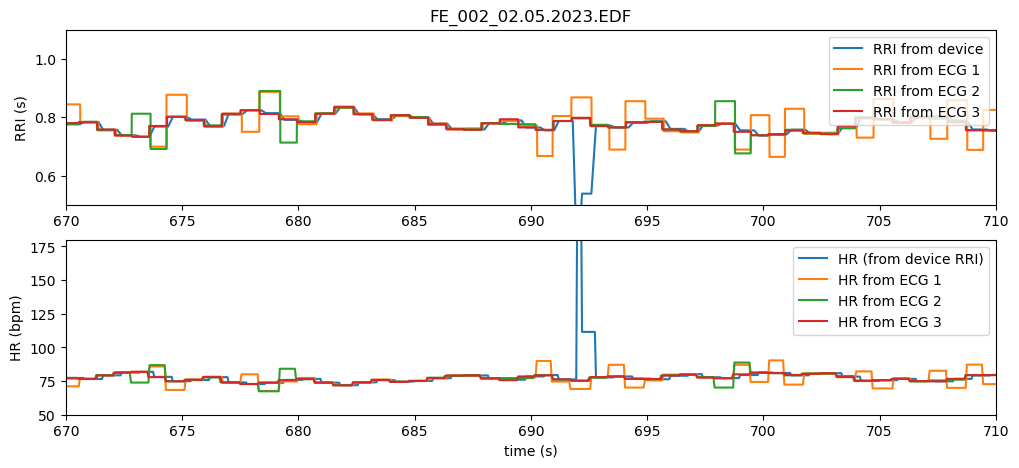

In [5]:
Fig = plt.figure(figsize=(12, 5))
P1 = Fig.add_subplot(2, 1, 1)
P2 = Fig.add_subplot(2, 1, 2, sharex=P1)

t = np.arange(ECG.shape[1])/sampling_rate
t_RRI = np.arange(RRI.size)/5
#P1.plot(t, clean_data, label='ECG')
P1.plot(t_RRI, RRI/1000, label='RRI from device')
for i in range(len(RRI_from_ECG_peaks)):
    P1.plot(t[:RRI_from_ECG_peaks[i].size], RRI_from_ECG_peaks[i], label='RRI from ECG %d' %(i+1))

P1.set_xlim(670, 710)
#P1.set_xlim(2050, 2090)
P1.set_ylim(0.5, 1.1)
P1.set_ylabel("RRI (s)")
P1.legend(loc='upper right')
P1.set_title(filename)

# Heart rate (HR) in bpm
P2.plot(t_HR, HR, label="HR (from device RRI)")
for i in range(len(HR_from_ECG)):
    P2.plot(t_HR_from_ECG[i], HR_from_ECG[i]/1000, label="HR from ECG %d" %(i+1))

P2.legend(loc='upper right')
P2.set_xlabel("time (s)")
P2.set_ylabel("HR (bpm)")
P2.set_ylim(50,180)


Fig.savefig("example5.pdf")